# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [11]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

# !wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

In [1]:
from collections import namedtuple
import itertools  

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [2]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [3]:
# First, lets load the dataset
data_train = dset.SVHN('data/', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))
data_test = dset.SVHN('data/', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [4]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [5]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [6]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [7]:
from torch.optim.lr_scheduler import StepLR

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        
        prediction = model(x_gpu)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y.shape[0]
    
    accuracy = float(correct_samples) / total_samples
    
    return accuracy


# loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [8]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('data/', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

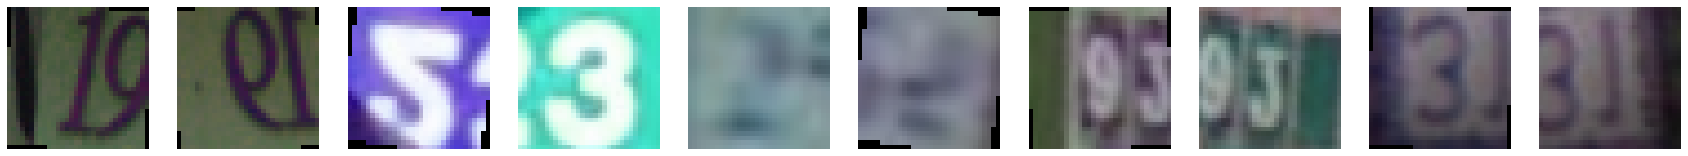

In [9]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('data/', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [10]:
# TODO: 
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_train_aug = dset.SVHN('data/', transform=tfs)

batch_size = 64

data_size = data_train_aug.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_aug_loader = torch.utils.data.DataLoader(data_train_aug, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [38]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.984505, Train accuracy: 0.684998, Val accuracy: 0.716470
Average loss: 0.721560, Train accuracy: 0.776593, Val accuracy: 0.807931
Average loss: 0.643498, Train accuracy: 0.803774, Val accuracy: 0.790663
Average loss: 0.600769, Train accuracy: 0.818363, Val accuracy: 0.811753
Average loss: 0.570214, Train accuracy: 0.826963, Val accuracy: 0.825063


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [42]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
                nn.Conv2d(3, 6, 5, padding=0),
                nn.MaxPool2d(2),
                nn.Conv2d(6, 16, 5, padding=0),
                nn.MaxPool2d(2),   
                Flattener(),
                nn.Linear(16*5*5, 120),
                nn.Linear(120, 84),
                nn.Linear(84, 10),
              )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(lenet_model.parameters(), betas=(0.9, 0.999), lr=1e-1, weight_decay=1e-4)
# optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 1017.881531, Train accuracy: 0.289066, Val accuracy: 0.512730
Average loss: 1.332206, Train accuracy: 0.599068, Val accuracy: 0.651150
Average loss: 1.079823, Train accuracy: 0.686466, Val accuracy: 0.729711
Average loss: 1.462811, Train accuracy: 0.704433, Val accuracy: 0.776329
Average loss: 0.786654, Train accuracy: 0.771525, Val accuracy: 0.786158
Average loss: 0.818669, Train accuracy: 0.760878, Val accuracy: 0.776124
Average loss: 0.888294, Train accuracy: 0.743269, Val accuracy: 0.772166
Average loss: 0.923322, Train accuracy: 0.730676, Val accuracy: 0.734557
Average loss: 0.954022, Train accuracy: 0.721820, Val accuracy: 0.736946
Average loss: 0.967997, Train accuracy: 0.714432, Val accuracy: 0.717357


# Подбор гиперпараметров

In [54]:
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'alpha', 'beta', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
alphas = [0.5, 0.7, 0.9, 0.99, 0.999]
betas = [0.5, 0.7, 0.9, 0.99, 0.999]
reg = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

batch_size = 64
epoch_num = 10

train_aug_loader = torch.utils.data.DataLoader(data_train_aug, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

random_params = list(itertools.product(learning_rates, alphas, betas, reg))
np.random.shuffle(random_params)

run_record = {} 

for i in random_params[:20]:
    hyperparams = Hyperparams(i[0], i[1], i[2], i[3])
    
    lenet_model = nn.Sequential(
                nn.Conv2d(3, 6, 5, padding=0),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(6, 16, 5, padding=0),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),   
                Flattener(),
                nn.Linear(16*5*5, 120),
                nn.ReLU(inplace=True),
                nn.Linear(120, 84),
                nn.ReLU(inplace=True),
                nn.Linear(84, 10),
              )

    lenet_model.type(torch.cuda.FloatTensor)
    lenet_model.to(device)

    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.Adam(lenet_model.parameters(), betas=(hyperparams.alpha, hyperparams.beta), 
                           lr=hyperparams.learning_rate, weight_decay=hyperparams.reg)
    loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, 
                                                           optimizer, epoch_num)
    
    runresult = RunResult(lenet_model, train_history, val_history, val_history[epoch_num-1])
    run_record[hyperparams] = runresult
    

Average loss: 1.924078, Train accuracy: 0.320360, Val accuracy: 0.569586
Average loss: 1.089735, Train accuracy: 0.652629, Val accuracy: 0.743908
Average loss: 0.785007, Train accuracy: 0.762482, Val accuracy: 0.800423
Average loss: 0.751364, Train accuracy: 0.798024, Val accuracy: 0.806771
Average loss: 1.106840, Train accuracy: 0.675511, Val accuracy: 0.579960
Average loss: 1.883171, Train accuracy: 0.520134, Val accuracy: 0.554501
Average loss: 1.841990, Train accuracy: 0.498089, Val accuracy: 0.458399
Average loss: 2.255154, Train accuracy: 0.390438, Val accuracy: 0.346256
Average loss: 43.306957, Train accuracy: 0.245299, Val accuracy: 0.200874
Average loss: 22414.300781, Train accuracy: 0.136471, Val accuracy: 0.083749
Average loss: 5617041513653877313130035245219840.000000, Train accuracy: 0.108453, Val accuracy: 0.095557
Average loss: nan, Train accuracy: 0.068099, Val accuracy: 0.066071
Average loss: nan, Train accuracy: 0.067911, Val accuracy: 0.066071
Average loss: nan, Trai

Average loss: 79851400.000000, Train accuracy: 0.164778, Val accuracy: 0.189816
Average loss: 104855111100811706368.000000, Train accuracy: 0.158721, Val accuracy: 0.181285
Average loss: 544874810360056042749952.000000, Train accuracy: 0.154114, Val accuracy: 0.145656
Average loss: 627601756174397854449664.000000, Train accuracy: 0.177849, Val accuracy: 0.189748
Average loss: 895601962799961330417664.000000, Train accuracy: 0.173293, Val accuracy: 0.081428
Average loss: 805627464177284726915072.000000, Train accuracy: 0.166809, Val accuracy: 0.189748
Average loss: 2748027605561576400093184.000000, Train accuracy: 0.182831, Val accuracy: 0.145587
Average loss: 214375368264729696709640192.000000, Train accuracy: 0.122564, Val accuracy: 0.101973
Average loss: 378517743659554259869892608.000000, Train accuracy: 0.101833, Val accuracy: 0.101973
Average loss: 378058825560488513644789760.000000, Train accuracy: 0.101781, Val accuracy: 0.101973
Average loss: 75369.031250, Train accuracy: 0.149

In [55]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.89, best hyperparams: Hyperparams(learning_rate=0.001, alpha=0.7, beta=0.9, reg=1e-06)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

Average loss: 0.720684, Train accuracy: 0.766014, Val accuracy: 0.873729
Average loss: 0.413582, Train accuracy: 0.870030, Val accuracy: 0.893113
Average loss: 0.355170, Train accuracy: 0.889704, Val accuracy: 0.904307
Average loss: 0.319847, Train accuracy: 0.902655, Val accuracy: 0.909494
Average loss: 0.289157, Train accuracy: 0.911135, Val accuracy: 0.910996
Average loss: 0.273348, Train accuracy: 0.916527, Val accuracy: 0.912088
Average loss: 0.251792, Train accuracy: 0.923779, Val accuracy: 0.916183
Average loss: 0.238028, Train accuracy: 0.927243, Val accuracy: 0.913931
Average loss: 0.222873, Train accuracy: 0.931321, Val accuracy: 0.919323
Average loss: 0.217773, Train accuracy: 0.933300, Val accuracy: 0.920620


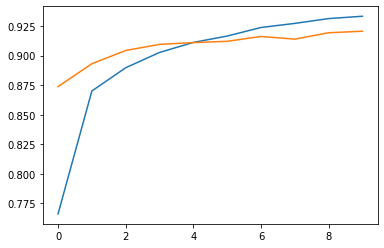

In [40]:
epoch_num = 10

best_model6 = nn.Sequential(
                nn.Conv2d(3, 14, 5, padding=2),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(14),
                nn.MaxPool2d(2),
                nn.Conv2d(14, 24, 5, padding=2),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(24),
                nn.MaxPool2d(2),
                nn.Conv2d(24, 28, 5, padding=2),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(28),
                nn.MaxPool2d(2),
                Flattener(),
                nn.Linear(28*4*4, 240),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(240),
                nn.Linear(240, 120),
                nn.ReLU(inplace=True),
                nn.Linear(120, 10),
              )

best_model6.type(torch.cuda.FloatTensor)
best_model6.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(best_model6.parameters(), betas=(0.9, 0.999), lr=0.001, weight_decay=1e-06)
loss_history, train_history, val_history = train_model(best_model6, train_aug_loader, val_loader, loss, 
                                                       optimizer, epoch_num)

plt.plot(train_history)
plt.plot(val_history)

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [41]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(best_model6, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9216733251382914
